In [1]:
import numpy as np
from scipy.stats import sem

# import my functions
# import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.stats import sem
from scipy.interpolate import interp1d


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = np.mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Signal

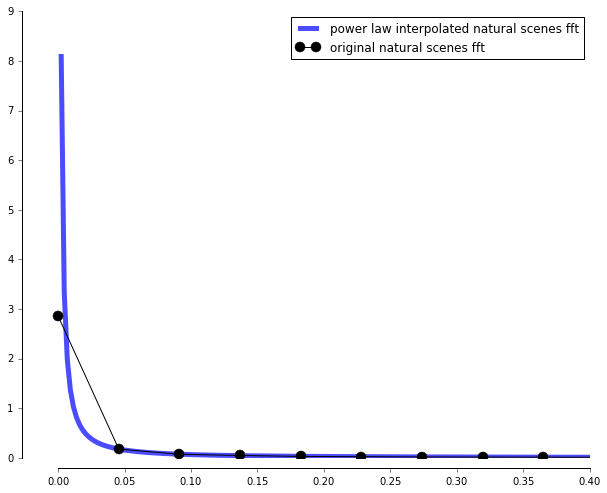

In [5]:
# interpolate signal amplitude
# power law
npoints = 10000
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
more_signal_freq   = np.linspace(0., originalFreqs[-1], npoints)[1:]
more_signal_amp = func(more_signal_freq, *popt)

plt.plot(more_signal_freq, more_signal_amp, 'b', linewidth=5, alpha=0.7, label='power law interpolated natural scenes fft')
plt.plot(originalFreqs, originalSpectra, 'k.-', markersize=20, label='original natural scenes fft')
plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Define information at a given frequency

In [6]:
def info_at_freq(freqs, signal_amplitude, filter_interpolation_function, function_const=1., input_noise=0.12, output_noise=0.35):
    numerator = (signal_amplitude * function_const * filter_interpolation_function(freqs))**2
    denominator = ((input_noise * function_const * filter_interpolation_function(freqs))**2 + output_noise**2)
    return 0.5*np.log2(1.0 + (numerator/denominator))

# Get center width from ganglion cell data

In [7]:
ganglion_rfs = load_ganglion_cells()
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 500, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0] - 0.25
mean_ganglion = np.mean(aligned_ganglion_rfs, axis=0)

In [8]:
def diff_of_gaussians(space, center_width, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=center_width, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [9]:
def diff_of_gaussians_fixed_center(space, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=1.751050, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [10]:
popt, pcov = curve_fit(diff_of_gaussians, valid_space, mean_ganglion, p0=[1.7, 7.4, -11, -60])
popt

array([  1.47729653,   8.46181925,  -6.11208239, -25.92723796])

In [11]:
difference = diff_of_gaussians(valid_space, *popt)

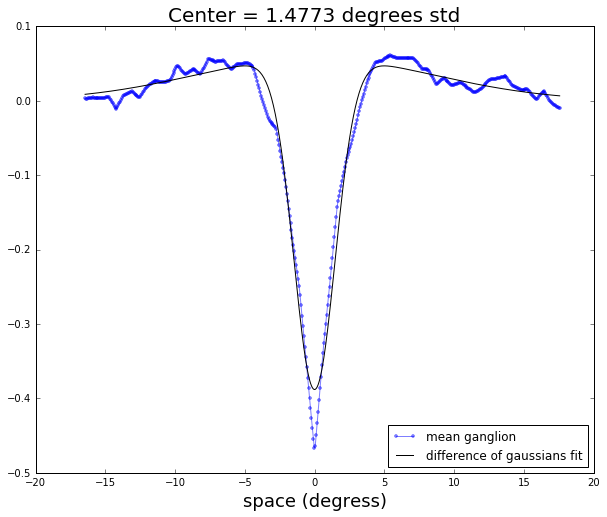

In [12]:
plot(valid_space, mean_ganglion, 'b.-', alpha=0.5, label='mean ganglion')
plot(valid_space, difference, 'k', label='difference of gaussians fit')
plt.legend(loc='lower right')
plt.xlabel('space (degress)', fontsize=18)
plt.title('Center = %0.4f degrees std' %(popt[0]), fontsize=20)

# Define model

In [13]:
def filter_model(horz_weight, ama_weight, center_weight, surround_weight, center_width=1.751050):
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:int((n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:int(((n-1)/2) + 1)]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

## Find ideal filter that maximizes information

In [14]:
input_noise = 0.12
output_noise = 0.35

The relative error from this choice of Lagrangian multiplier is 1.93148725626e-07.


/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


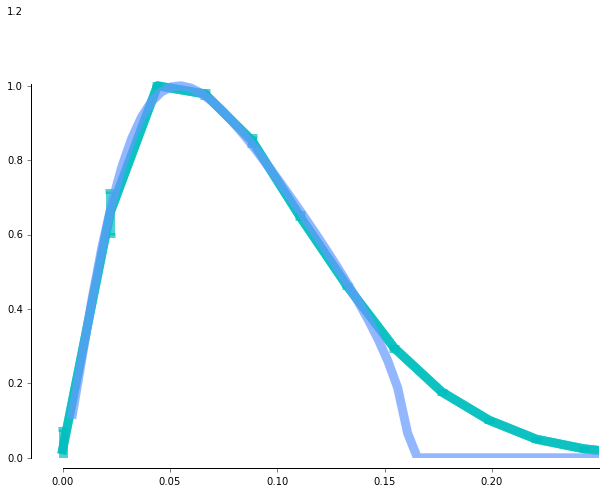

In [15]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=input_noise, outputNoise=output_noise,
                                                                     center_weighting=7.7844, surround_weighting=.5085,
                                                                     horz_weighting=.223, ama_weighting=1.165,
                                                                     center_width=1.86945,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                                       statistics=True)

#### And make an interpolation of it

In [16]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='linear', 
                               bounds_error=False, fill_value='extrapolate')
output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(output_variance)

1227.34527187


(0, 0.3)

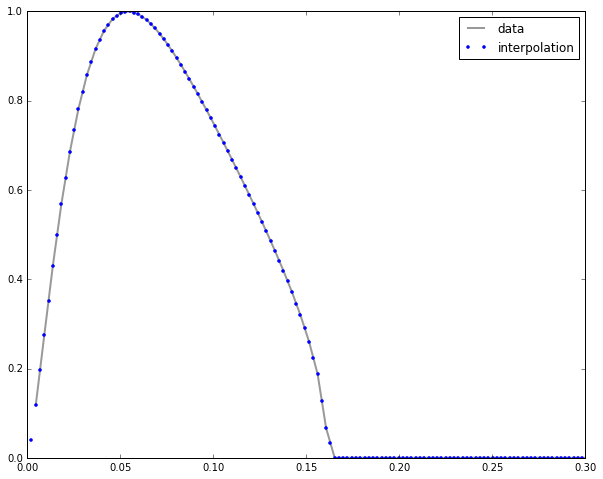

In [17]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), 'k', linewidth=2, alpha=0.4, label='data')
plt.plot(more_signal_freq, ideal_filter_interp(more_signal_freq), 'b.', label='interpolation')
plt.legend()
plt.xlim([0,0.3])

# Now fit the models (full, horizontal only, amacrine only) to ideal filter

In [18]:
popt[0]

1.4772965311658066

In [19]:
cutoff = 0.4
center_width = popt[0]

### Full model

In [20]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
model_freqs, model_fft, horz_weight, ama_weight, center_weight, surround_weight, center_width = fit_ideal(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs),
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
model_interp, model_popt = fit_ideal(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(model_popt)
print('Horizontal weight is %f, Amacrine weight is %f' %(horz_weight, ama_weight))
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 0.99700996 -0.37136047  5.10571889  0.51215078]
Horizontal weight is 0.985740, Amacrine weight is -0.316720
Center weight is 5.215843, Surround weight is 0.505242
Center is 1.477297 std wide


(0, 0.4)

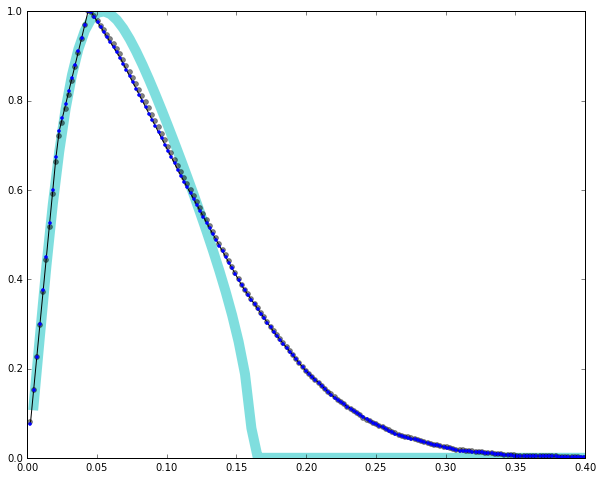

In [21]:
model_filter_interp = filter_model(*model_popt, center_width=center_width)
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='c', linewidth=10, alpha=0.5)
plt.plot(model_freqs, model_fft, 'k.', linewidth=2, markersize=10, alpha=0.5)
plt.plot(lowerer_freqs, model_filter_interp(lowerer_freqs)/np.nanmax(model_filter_interp(lowerer_freqs)), 'k')
plt.plot(model_freqs, model_interp(model_freqs, *model_popt), 'b.')
plt.xlim([0,.4])

### Horizontal model

In [22]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
h_freqs, h_fft, center_weight, surround_weight, center_width = fit_ideal_horz_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
h_interp, h_popt = fit_ideal_horz_only(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(h_popt)
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 0.7619803   0.05688096]
Center weight is 0.761980, Surround weight is 0.056881
Center is 1.477297 std wide


In [23]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
a_freqs, a_fft, center_weight, surround_weight, center_width = fit_ideal_ama_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
a_interp, a_popt = fit_ideal_ama_only(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(a_popt)
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 83262.19375123   9105.94196766]
Center weight is 183.800301, Surround weight is 20.102100
Center is 1.477297 std wide


(0, 1.1)

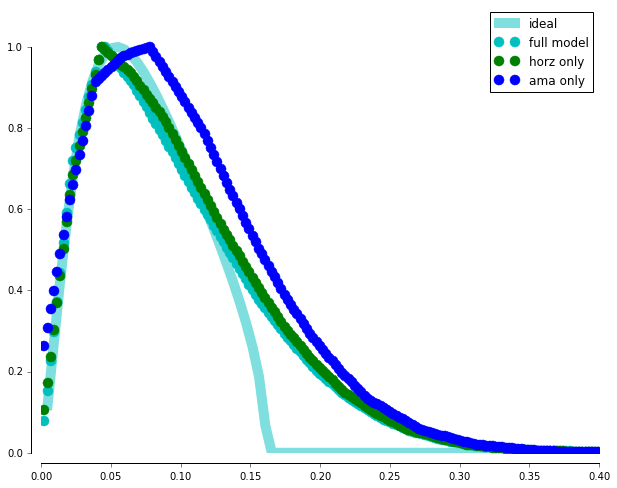

In [24]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='c', linewidth=10, alpha=0.5, label='ideal')
plt.plot(model_freqs, model_fft, 'c.', linewidth=2, markersize=20, label='full model')
plt.plot(h_freqs, h_fft, 'g.', linewidth=2, markersize=20, label='horz only')
plt.plot(a_freqs, a_fft, 'b.', linewidth=2, markersize=20, label='ama only')
plt.xlim([0,.4])
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([0,1.1])

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


The relative error from this choice of Lagrangian multiplier is 2.09332807841e-07.


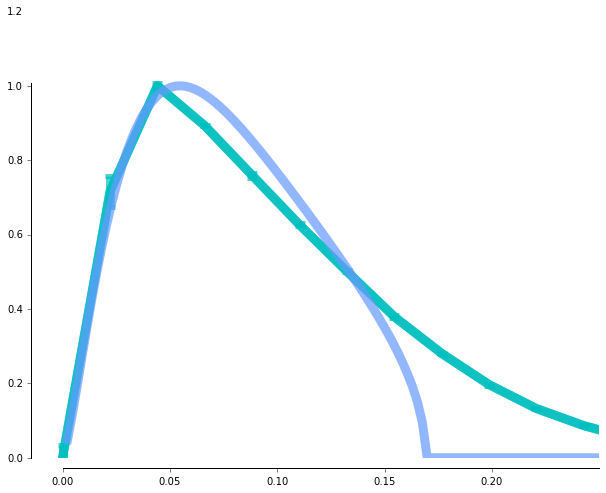

In [25]:
horz_weight, ama_weight, center_weight, surround_weight = model_popt
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=horz_weight, ama_weighting=ama_weight,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                                       statistics=True)

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


The relative error from this choice of Lagrangian multiplier is 8.78585179927e-08.


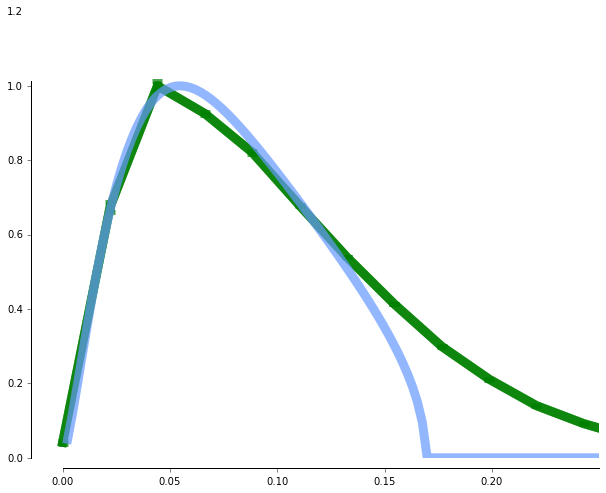

In [26]:
horz_weight = 1.0
ama_weight = 0.0
center_weight, surround_weight = h_popt
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h, h_freqs, h_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=1.0, ama_weighting=0.0,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                     aggregateColor='g', statistics=True)

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


The relative error from this choice of Lagrangian multiplier is 1.00784287386e-07.


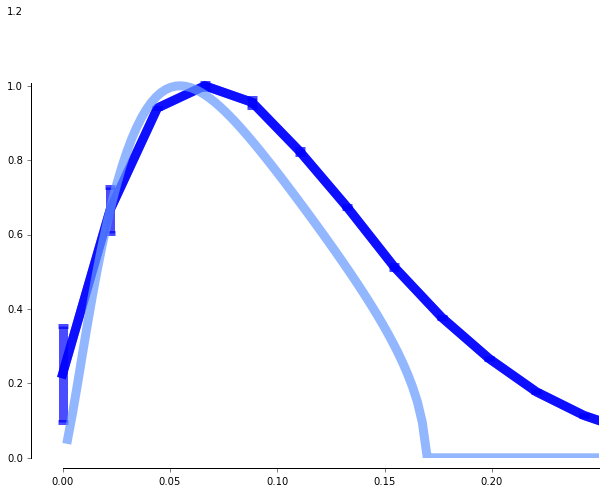

In [27]:
horz_weight = 0.0
ama_weight = 1.0
center_weight, surround_weight = a_popt
freq_ideal, filt_ideal, freq_expt_a, filt_expt_a, a_freqs, a_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=horz_weight, ama_weighting=ama_weight,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                     aggregateColor='b', statistics=True)

In [28]:
lower_freqs = lowerer_freqs

In [29]:
np.max(lowerer_freqs)

0.39944589697064947

In [30]:
init_model_const = 0.95
init_a_const = 0.95
init_h_const = 0.95

In [31]:
model_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_model_var(model_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    model_variance = np.sum((signal_interp(lower_freqs)*model_const*model_interp(lower_freqs))**2 +
                          (input_noise * model_const * model_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - model_variance)**2

In [32]:
model_const_opt = scipy.optimize.minimize(constrain_model_var, init_model_const)
model_const = abs(model_const_opt['x'])
model_const_opt

      fun: 2.3766466260422878e-14
 hess_inv: array([[ 0.01716246]])
      jac: array([ -1.23057404e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 0.91384802])

In [33]:
model_variance = np.sum((more_signal_amp*model_const*model_interp(more_signal_freq))**2 +
                          (input_noise * model_const * model_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(model_variance)

1227.34527496


In [34]:
a_interp = interp1d(freq_expt_both, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

def constrain_a_var(a_const):
    output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    a_variance = np.sum((more_signal_amp*a_const*a_interp(more_signal_freq))**2 +
                          (input_noise * a_const * a_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    
    return (output_variance - a_variance)**2

In [35]:
a_const_opt = scipy.optimize.minimize(constrain_a_var, init_a_const)
a_const = abs(a_const_opt['x'])
a_const_opt

      fun: 1.6285449827931491e-13
 hess_inv: array([[ 0.0056512]])
      jac: array([ -6.28035271e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 4
     njev: 10
   status: 0
  success: True
        x: array([-0.52397475])

In [36]:
a_variance = np.sum((more_signal_amp*a_const*a_interp(more_signal_freq))**2 +
                          (input_noise * a_const * a_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(a_variance)

1227.34527228


In [37]:
h_interp = interp1d(freq_expt_both, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

def constrain_h_var(h_const):
    output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    h_variance = np.sum((more_signal_amp*h_const*h_interp(more_signal_freq))**2 +
                          (input_noise * h_const * h_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    
    return (output_variance - h_variance)**2

In [38]:
h_const_opt = scipy.optimize.minimize(constrain_h_var, init_h_const)
h_const = abs(h_const_opt['x'])
h_const_opt

      fun: 2.7959649771066874e-15
 hess_inv: array([[ 0.0147536]])
      jac: array([ -1.10755585e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 0.84804453])

In [39]:
h_variance = np.sum((more_signal_amp*h_const*h_interp(more_signal_freq))**2 +
                          (input_noise * h_const * h_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(h_variance)

1227.34527182


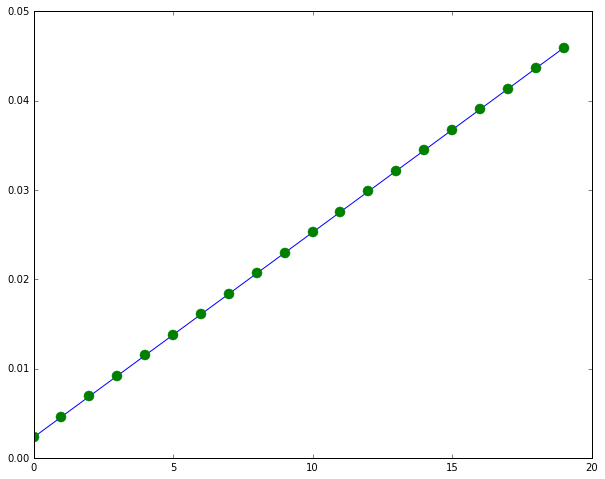

In [40]:
plt.plot(more_signal_freq[:20])
plt.plot(lower_freqs[:20], '.', markersize=20)

In [41]:
lower_amps = np.array([more_signal_amp[i] for i in range(len(more_signal_amp)) if more_signal_freq[i] <= np.max(lower_freqs)])
print(len(lower_amps))
print(len(lower_freqs))

174
174


In [42]:
cuminfo_ideal = info_at_freq(lower_freqs, lower_amps, ideal_filter_interp, output_noise=output_noise, input_noise=input_noise)
cuminfo_model = info_at_freq(lower_freqs, lower_amps, model_interp, function_const=model_const, output_noise=output_noise, input_noise=input_noise)
cuminfo_a = info_at_freq(lower_freqs, lower_amps, a_interp, function_const=a_const, output_noise=output_noise, input_noise=input_noise)
cuminfo_h = info_at_freq(lower_freqs, lower_amps, h_interp, function_const=h_const, output_noise=output_noise, input_noise=input_noise)

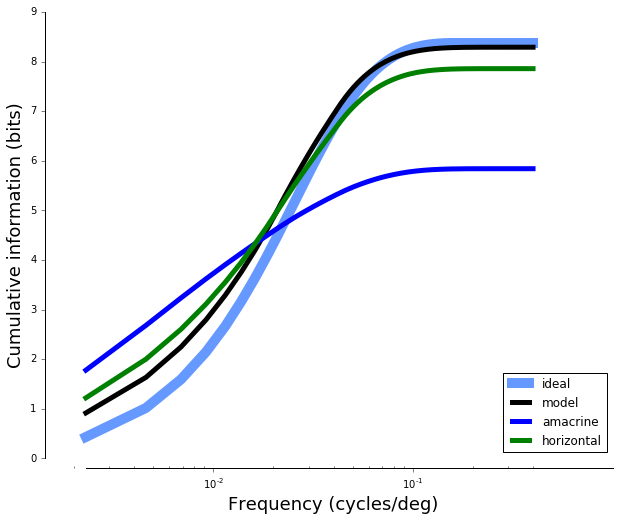

In [43]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

## How much information do ganglion cell RFs transmit?

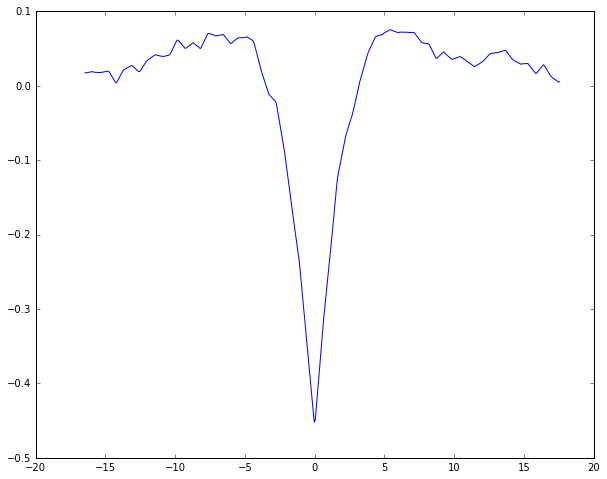

In [44]:
plt.plot(valid_space, mean_ganglion-np.mean(mean_ganglion))

In [45]:
rf_f_two_sided = abs(np.fft.fft(mean_ganglion-np.mean(mean_ganglion))) / np.prod(mean_ganglion.shape)
n = len(rf_f_two_sided)
if n % 2 == 0:
    rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
else:
    rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
spacing = valid_space[-1] - valid_space[-2]
rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

ganglion_freqs = rf_freqs_one_sided
ganglion_amps = rf_f_one_sided

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 4)

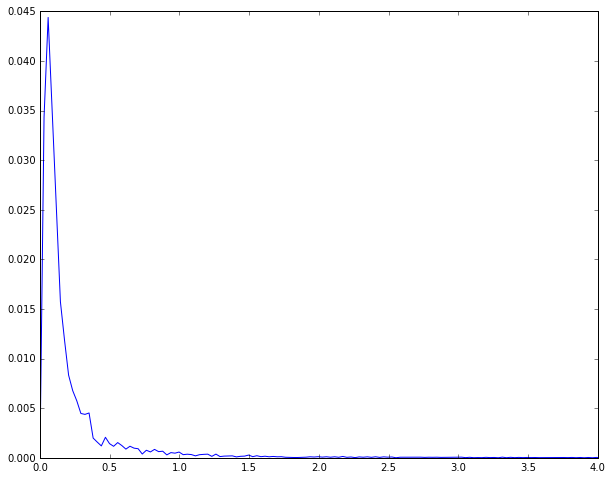

In [207]:
plt.plot(ganglion_freqs, ganglion_amps)
plt.xlim([0,4])

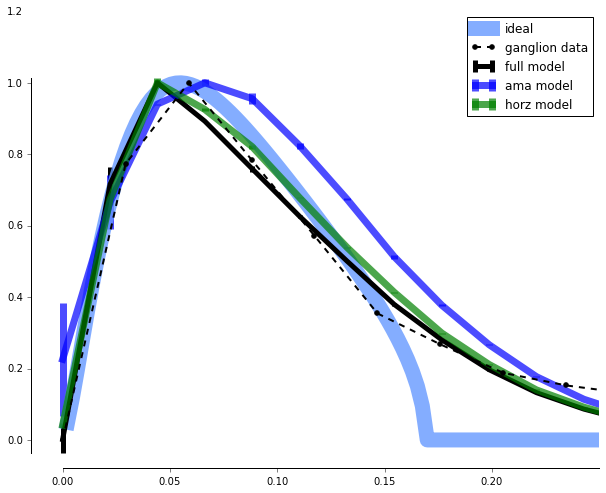

In [47]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='#6699ff', linewidth=15, alpha=0.8, label='ideal')
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0, label='full model')
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0, label='ama model')
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0, label='horz model')
plt.plot(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), 'k.--', markersize=10, linewidth=2, label='ganglion data')
# plt.plot(a_freqs, a_fft, 'b.', linewidth=2, markersize=20, label='ama only', alpha=0.5)
plt.xlim([-0.01,0.25])
plt.ylim([-0.05, 1.2])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.legend()
# plt.savefig('Fig4B-C_one_plot.pdf', fonttype=42)

In [48]:
ganglion_interp = interp1d(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_ganglion_var(ganglion_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    ganglion_variance = np.sum((signal_interp(lower_freqs)*ganglion_const*ganglion_interp(lower_freqs))**2 +
                          (input_noise * ganglion_const * ganglion_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - ganglion_variance)**2

In [49]:
init_ganglion_const = 1.02

In [50]:
ganglion_const_opt = scipy.optimize.minimize(constrain_ganglion_var, init_ganglion_const)
ganglion_const = ganglion_const_opt['x']
ganglion_const_opt

      fun: 1.269277814156533e-15
 hess_inv: array([[ 0.02226496]])
      jac: array([ -3.05372792e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 1.04157983])

In [51]:
cuminfo_ganglion = info_at_freq(lower_freqs, lower_amps, ganglion_interp, function_const=ganglion_const, output_noise=output_noise, input_noise=input_noise)

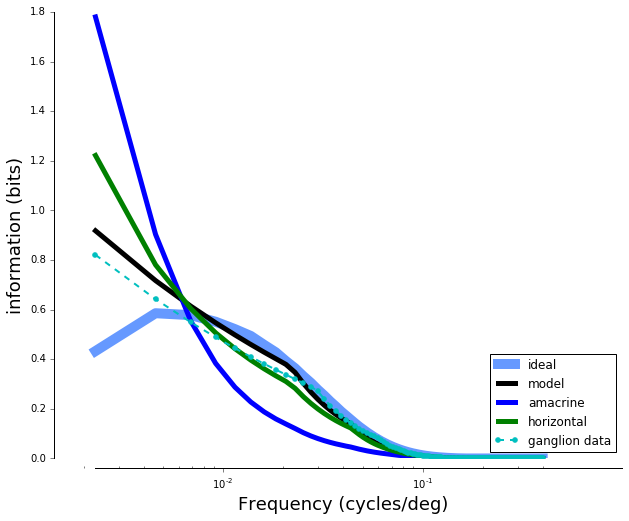

In [52]:
plt.plot(lower_freqs, cuminfo_ideal, color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, cuminfo_model, color='k', linewidth=5, label='model')
plt.plot(lower_freqs, cuminfo_a, color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, cuminfo_h, color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, cuminfo_ganglion, 'c.--', linewidth=2, markersize=10, label='ganglion data')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

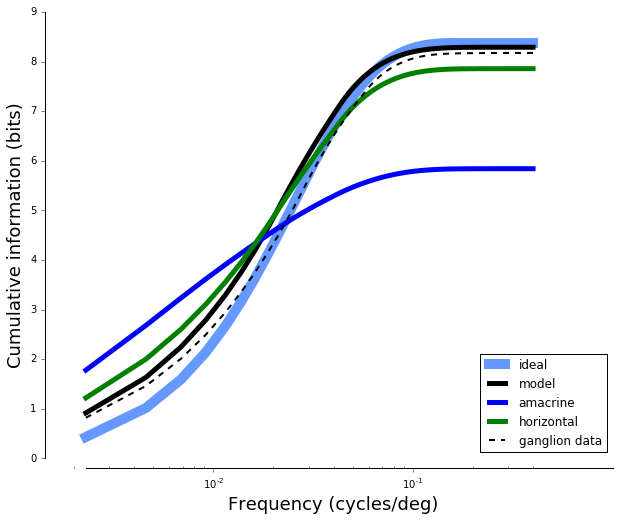

In [53]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, np.cumsum(cuminfo_ganglion), 'k--', linewidth=2, markersize=10, label='ganglion data')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

In [54]:
np.sum(cuminfo_ganglion)

8.1759171959759893

In [55]:
np.sum(cuminfo_ideal)

8.3767505349296734

In [56]:
np.sum(cuminfo_ganglion)/np.sum(cuminfo_ideal)

0.97602491107784073

In [57]:
np.sum(cuminfo_model)/np.sum(cuminfo_ideal)

0.9898453640638557

In [58]:
np.sum(cuminfo_h)/np.sum(cuminfo_ideal)

0.9382623538370467

In [59]:
np.sum(cuminfo_a)/np.sum(cuminfo_ideal)

0.69744842114530692

## Plot cumulative information including center

In [60]:
center = gaussian(x=valid_space, sigma=center_width, mu=0)
rf_f_two_sided = abs(np.fft.fft(center)) / np.prod(center.shape)
n = len(rf_f_two_sided)
if n % 2 == 0:
    rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
else:
    rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
spacing = valid_space[-1] - valid_space[-2]
rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

center_freqs = rf_freqs_one_sided
center_amps = rf_f_one_sided

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1)

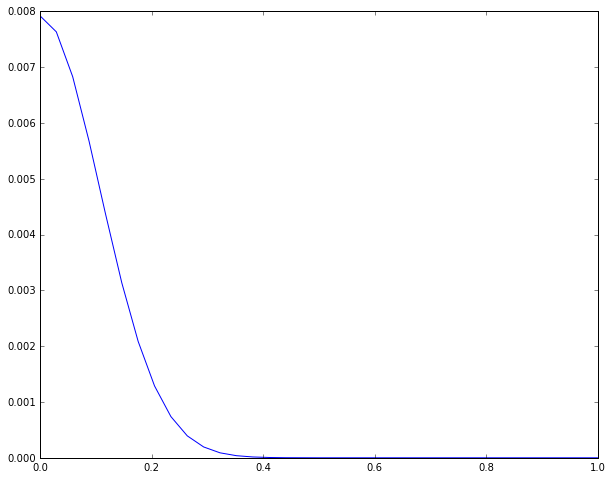

In [61]:
plt.plot(center_freqs, center_amps)
plt.xlim([0,1])

In [62]:
center_interp = interp1d(center_freqs, center_amps/np.nanmax(center_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_center_var(center_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    center_variance = np.sum((signal_interp(lower_freqs)*center_const*center_interp(lower_freqs))**2 +
                          (input_noise * center_const * center_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - center_variance)**2


In [63]:
init_center_const = 0.7
center_const_opt = scipy.optimize.minimize(constrain_center_var, init_center_const)
center_const = abs(center_const_opt['x'])
center_const_opt

      fun: 4.7218040226525195e-14
 hess_inv: array([[ 0.00058901]])
      jac: array([ -1.36795262e-08])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([-0.16941062])

In [64]:
cuminfo_center = info_at_freq(lower_freqs, lower_amps, center_interp, function_const=center_const, output_noise=output_noise, input_noise=input_noise)

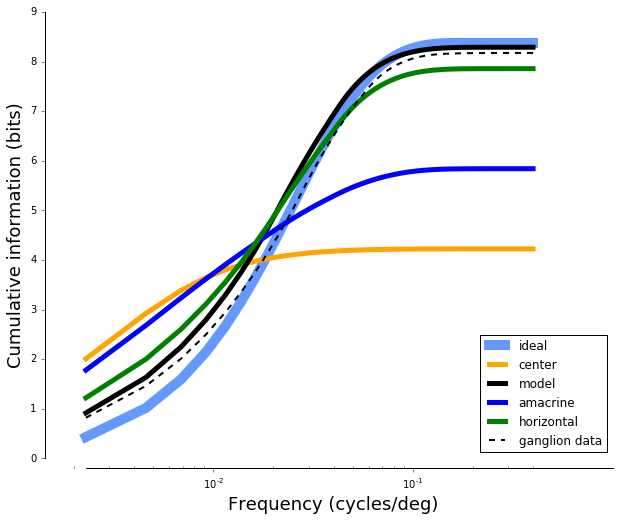

In [65]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_center), 'orange', linewidth=5, label='center')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, np.cumsum(cuminfo_ganglion), 'k--', linewidth=2, markersize=10, label='ganglion data')

plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.savefig('Cumulative_info_plot.pdf', fonttype=42)

# Generate colormaps of information as fn of model params

In [238]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    traceback.print_stack()
    log = file if hasattr(file,'write') else sys.stderr
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [302]:
resolution = 40
horz_weights = np.linspace(0.,1.,resolution)
center_weights = np.linspace(0.8,1.0,resolution)
init_filt_const = 0.8

info_color_map = np.zeros((resolution, resolution))
mse_color_map = np.zeros((resolution, resolution))

for idh,hw in enumerate(horz_weights):
    for idc,cw in enumerate(center_weights):
        aw = 1.0 - hw
        sw = 1.0 - cw
        filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

        def constrain_filt_var(filt_const):
            output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                                  (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                                  (output_noise)**2)
            filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                                  (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                                  (output_noise)**2)

            return (output_variance - filt_variance)**2


        filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
        filt_const = abs(filt_const_opt['x'])
        
        # compute total information for this particular model
        info_color_map[idh,idc] = np.sum(info_at_freq(more_signal_freq, more_signal_amp, 
                                                              filt_interp, function_const=filt_const))
        
        # compute the MSE difference between this model filter and the ideal filter
        mse_color_map[idh,idc] = np.mean((ideal_filter_interp(more_signal_freq) - filt_const*filt_interp(more_signal_freq))**2)
        
    if idh % 5 == 0:
        print('On iteration %d/%d' %(idh*resolution, resolution*resolution))


On iteration 0/1600
On iteration 200/1600
On iteration 400/1600
On iteration 600/1600
On iteration 800/1600
On iteration 1000/1600
On iteration 1200/1600
On iteration 1400/1600


### Colormap of horizontal/amacrine allocation vs center/surround allocation

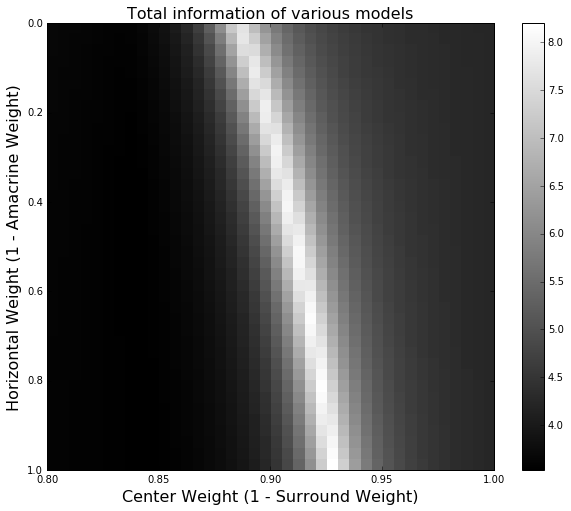

In [309]:
plt.imshow(info_color_map, cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

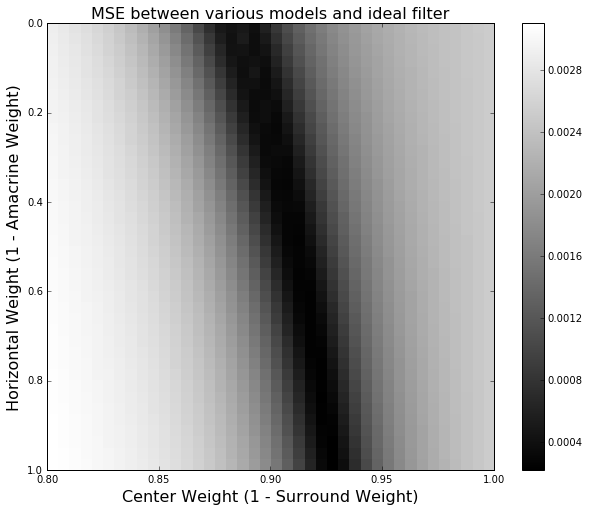

In [304]:
plt.imshow(mse_color_map, cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('MSE between various models and ideal filter', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

# Correlation between MSE and Info

(0, 0.005)

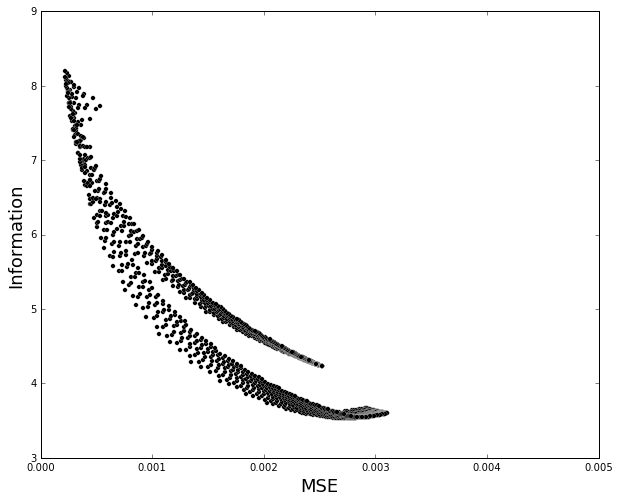

In [317]:
plt.scatter(mse_color_map.flat, info_color_map.flat, c='k', edgecolors='white', linewidths=0.2)
plt.xlabel('MSE', fontsize=18)
plt.ylabel('Information', fontsize=18)
plt.xlim([0,0.005])

## Plot the solutions at opposite extremes of horz/ama weighting - how different do they look?

In [320]:
opposite_filters = []
hws = [horz_weights[1], horz_weights[-2]]
cws = []

for hw in hws:
    aw = 1.0 - hw
    cw = center_weights[np.argmax(info_color_map[np.argmin(abs(hw - horz_weights))])]
    sw = 1.0 - cw
    cws.append(cw)
    print('Horz weight %f, center weight %f, info %f' %(hw, cw, np.max(info_color_map[np.argmin(abs(hw - horz_weights))])))

    filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

    def constrain_filt_var(filt_const):
        output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                              (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                              (output_noise)**2)
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (output_variance - filt_variance)**2


    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    opposite_filters.append(filt_const * filt_interp(more_signal_freq))

Horz weight 0.025641, center weight 0.887179, info 7.724446
Horz weight 0.974359, center weight 0.928205, info 8.119446


(0, 0.4)

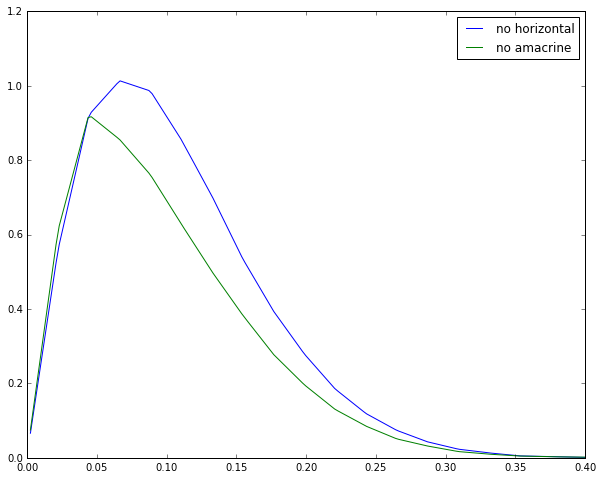

In [327]:
plt.plot(more_signal_freq, opposite_filters[0], 'b', label='no horizontal')
plt.plot(more_signal_freq, opposite_filters[1], 'g', label='no amacrine')
plt.legend()
plt.xlim([0,0.4])

In [315]:
filt_variance = np.sum((signal_interp(more_signal_freq)*opposite_filters[0])**2 +
                              (input_noise * opposite_filters[0])**2 +
                              (output_noise)**2)
filt_variance

1227.3452726227285

In [316]:
filt_variance = np.sum((signal_interp(more_signal_freq)*opposite_filters[1])**2 +
                              (input_noise * opposite_filters[1])**2 +
                              (output_noise)**2)
filt_variance

1227.3452824649037

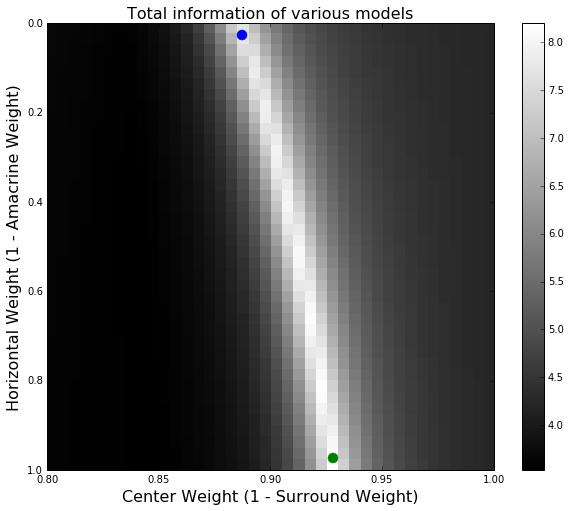

In [328]:
plt.imshow(info_color_map, cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.plot(cws[0], hws[0], 'b.', markersize=20)
plt.plot(cws[1], hws[1], 'g.', markersize=20)
plt.xlim([0.8,1])
plt.colorbar()
plt.title('Total information of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

## Modify filter_model to accept normalized parameters

In [330]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
model_freqs, model_fft, horz_weight, ama_weight, center_weight, surround_weight, center_width = fit_ideal(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs),
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
model_interp, model_popt = fit_ideal(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(model_popt)
print('Horizontal weight is %f, Amacrine weight is %f' %(horz_weight, ama_weight))
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 0.99438171 -0.36902248  5.10310355  0.51190443]
Horizontal weight is 1.932254, Amacrine weight is -0.719715
Center weight is 7.533568, Surround weight is 0.392043
Center is 1.477297 std wide


## Wait a minute - right now I'm forcing all the weights to be positive... so the surround is not subtracted from the center!!

In [331]:
horz_weight = hws[0]
ama_weight = 1.0 - hws[0]
center_weight = cws[0]
surround_weight = 1.0 - cws[0]

horz_pfs = get_horizontal_projective_field()
ama_pfs  = get_amacrine_projective_field()

# get means of the projective fields
space_h, horz_pf, horz_sem = get_mean(horz_pfs)
space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

# interpolate horz and ama to get a unified space; mode='valid'
horz_interp = interp1d(space_h, horz_pf, kind='slinear')
ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

# project interpolations on unified space
horz_pf     = horz_interp(space)
ama_pf      = ama_interp(space)

# set sampling rate
spacing = space[-1] - space[-2]

# make surround
surround = horz_weight * horz_pf + ama_weight * ama_pf

# make center
center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

# put them together
if len(center.shape) > 1:
    center = center.squeeze()
rf = center_weight * center + surround_weight * surround

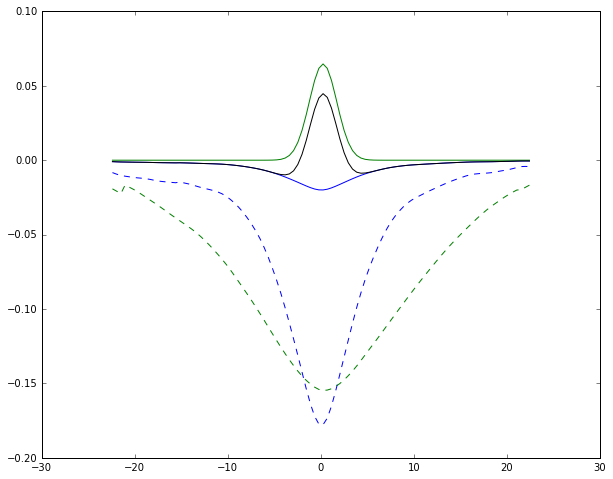

In [341]:
plt.plot(space, surround_weight*surround)
plt.plot(space, center_weight*center)
plt.plot(space, center_weight*center + surround_weight*surround, 'k')
plt.plot(space, ama_pf, 'b--')
plt.plot(space, horz_pf, 'g--')

In [342]:
center_width

1.4772965311658066

In [87]:
def filter_express(horz_weight, center_weight, center_width=center_width):
    horz_weight = np.min([1.0, abs(horz_weight)])
    ama_weight = 1.0 - horz_weight
    center_weight = np.min([1.0, abs(center_weight)])
    surround_weight = 1.0 - center_weight
    
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:int((n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:int(((n-1)/2) + 1)]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

In [88]:
def info_fun(weights, center_width=center_width, init_filt_const=0.8):
    horz_weight, center_weight = weights
    
    # get model
    filt_interp = filter_express(horz_weight, center_weight, center_width=center_width)
    
    # constrain variance
    def constrain_filt_var(filt_const):
        output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                              (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                              (output_noise)**2)
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (output_variance - filt_variance)**2
    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    # get info
    infos = info_at_freq(more_signal_freq, more_signal_amp, filt_interp, function_const=filt_const, input_noise=0.12, output_noise=0.35)
    return -np.sum(infos)

In [89]:
info_fun([0.55, 0.45])

-3.7759227870030738

In [90]:
initial = np.random.rand(2)
popt = scipy.optimize.minimize(info_fun, initial)

In [91]:
popt

      fun: -3.9092787030071783
 hess_inv: array([[ 0.00057886,  0.01200891],
       [ 0.01200891,  0.33532968]])
      jac: array([-0.48904943,  0.00824431])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 275
      nit: 9
     njev: 67
   status: 2
  success: False
        x: array([ 0.04815762,  0.00130805])

In [92]:
initial

array([ 0.28037685,  0.36677983])

## Scipy.optimize.minimize takes too long... let's use descent

In [373]:
import traceback
import warnings
import sys
warnings.showwarning = None

In [374]:
import descent

In [375]:
? descent.GradientDescent

In [111]:
def gradient_descent(fun, x0, maxiters=1000, lr=1e-2, tol=1e-4):
    x_opt = x0
    up_step_history = []
    down_step_history = []
    gradient_history = []
    x_history = [x_opt]
    
    for i in range(maxiters):
        step = 0.1*np.random.rand(np.prod(x_opt.shape))
        gradient = []
        for s in range(len(step)):
            x_up = x_opt.copy()
            x_up[s] += step[s]
            x_down = x_opt.copy()
            x_down[s] -= step[s]
            up_step = fun(x_up)
            down_step = fun(x_down)
            g = (up_step - down_step)/(2.0*step[s])
            gradient.append(g)
            
            # keep track of histories
            up_step_history.append(up_step)
            down_step_history.append(down_step)
            gradient_history.append(gradient)
            
        x_new = x_opt - lr * np.array(gradient)
        x_history.append(x_new)
        if np.sum(abs(x_new - x_opt)) < tol:
#             import pdb
#             pdb.set_trace()
            return {'x':x_new, 'fun': fun(x_new), 'grad': np.array(gradient), 'niters':i, 'step':step,
                   'up_step_history':up_step_history, 'down_step_history':down_step_history,
                   'gradient_history':gradient_history}
        else:
            x_opt = x_new
    return {'x':x_new, 'fun': fun(x_new), 'grad': np.array(gradient), 'niters':i, 'step':step,
            'up_step_history':up_step_history, 'down_step_history':down_step_history,
            'gradient_history':gradient_history}

In [116]:
def proximal_gradient_descent(fun, x0, maxiters=1000, lr=1e-2, tol=1e-4):
    x_opt = x0
    up_step_history = []
    down_step_history = []
    gradient_history = []
    x_history = [x_opt]
    
    for i in range(maxiters):
        step = 0.1*np.random.rand(np.prod(x_opt.shape))
        gradient = []
        x_up = x_opt.copy()
        x_up += step
        x_down = x_opt.copy()
        x_down -= step
        up_step = fun(x_up)
        down_step = fun(x_down)
        gradient = (up_step - down_step)/(2.0*step)
            
        # keep track of histories
        up_step_history.append(up_step)
        down_step_history.append(down_step)
        gradient_history.append(gradient)
            
        x_new = x_opt - lr * np.array(gradient)
        x_history.append(x_new)
        if np.sum(abs(x_new - x_opt)) < tol:
#             import pdb
#             pdb.set_trace()
            return {'x':x_new, 'fun': fun(x_new), 'grad': np.array(gradient), 'niters':i, 'step':step,
                   'up_step_history':up_step_history, 'down_step_history':down_step_history,
                   'gradient_history':gradient_history}
        else:
            x_opt = x_new
    return {'x':x_new, 'fun': fun(x_new), 'grad': np.array(gradient), 'niters':i, 'step':step,
            'up_step_history':up_step_history, 'down_step_history':down_step_history,
            'gradient_history':gradient_history}

In [146]:
init = np.array([0.1, 0.88]) #np.random.rand(2)
popt = proximal_gradient_descent(info_fun, init, lr=5e-6, tol=1e-5)

In [147]:
popt['fun']

-3.5538212116984074

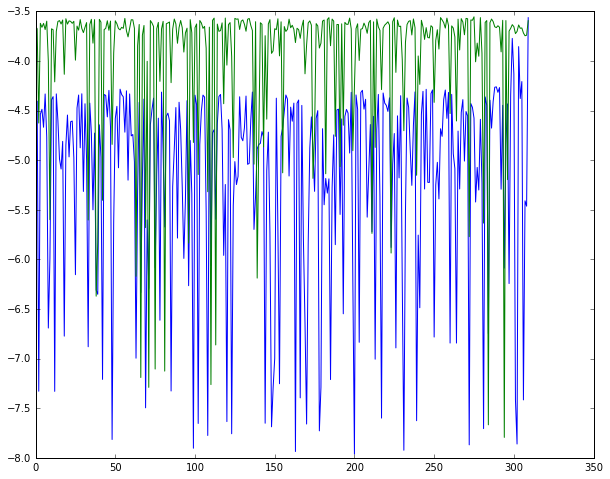

In [148]:
plt.plot(popt['up_step_history'])
plt.plot(popt['down_step_history'])

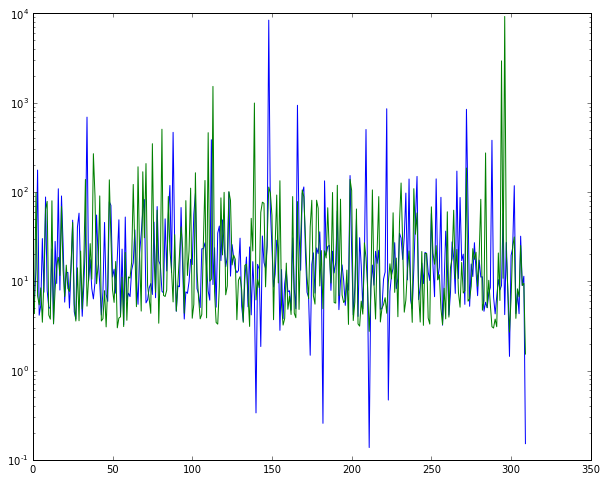

In [149]:
plt.plot([abs(g) for g in popt['gradient_history']])
plt.yscale('log')

## Try again with Niru's descent package

In [152]:
import traceback
import warnings
import sys
warnings.showwarning = None

In [170]:
import descent

[autoreload of descent.utils failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'is_arity'
]


In [171]:
# optimize with gradient descent
learning_rate = 1e-2d
x0 = np.array([0.2, 0.8]).astype('float32')
optimizer = descent.GradientDescent(x0, info_fun, 'sgd', {'lr': learning_rate})
optimizer.run(maxiter=100)

+-----------+------------+-----------+
|Iteration  | Objective  | Runtime   |
+-----------+------------+-----------+


TypeError: 'numpy.float64' object is not iterable

In [178]:
%debug

> /Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/toolz-0.7.4-py3.5.egg/toolz/itertoolz.py(327)second()

ipdb> up
> /Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/toolz-0.7.4-py3.5.egg/toolz/functoolz.py(381)__call__()

ipdb> up
> /Users/lmcintosh/code/descent/descent/main.py(107)__next__()
    106 
--> 107         grad = self.gradient(destruct(self.theta))
    108         xk = self.algorithm(grad)

ipdb> print(self.theta)
[ 0.2         0.80000001]
ipdb> type(self.theta)
<class 'numpy.ndarray'>
ipdb> destruct(self.theta)
array([ 0.2       ,  0.80000001], dtype=float32)
ipdb> self.gradient
ipdb> self.gradient(self.theta)
*** TypeError: 'numpy.float64' object is not iterable
ipdb> q


In [176]:
from descent import destruct

In [ ]:
destruct()

In [172]:
info_fun(x0)

-3.6411970497438007

In [173]:
from descent.utils import destruct

In [174]:
destruct(optimizer.theta)

array([ 0.2       ,  0.80000001], dtype=float32)

In [177]:
destruct(x0)

array([ 0.2       ,  0.80000001], dtype=float32)

# Just do a finer grid-search

In [179]:
resolution = 150
horz_weights = np.linspace(0.,1.,resolution)
center_weights = np.linspace(0.83,1.0,resolution)
init_filt_const = 0.8

info_color_map = np.zeros((resolution, resolution))
mse_color_map = np.zeros((resolution, resolution))

for idh,hw in enumerate(horz_weights):
    for idc,cw in enumerate(center_weights):
        aw = 1.0 - hw
        sw = 1.0 - cw
        filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

        def constrain_filt_var(filt_const):
            output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                                  (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                                  (output_noise)**2)
            filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                                  (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                                  (output_noise)**2)

            return (output_variance - filt_variance)**2


        filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
        filt_const = abs(filt_const_opt['x'])
        
        # compute total information for this particular model
        info_color_map[idh,idc] = np.sum(info_at_freq(more_signal_freq, more_signal_amp, 
                                                              filt_interp, function_const=filt_const))
        
        # compute the MSE difference between this model filter and the ideal filter
        mse_color_map[idh,idc] = np.mean((ideal_filter_interp(more_signal_freq) - filt_const*filt_interp(more_signal_freq))**2)
        
    if idh % 5 == 0:
        print('On iteration %d/%d' %(idh*resolution, resolution*resolution))


On iteration 0/22500
On iteration 750/22500
On iteration 1500/22500
On iteration 2250/22500
On iteration 3000/22500
On iteration 3750/22500
On iteration 4500/22500
On iteration 5250/22500
On iteration 6000/22500
On iteration 6750/22500
On iteration 7500/22500
On iteration 8250/22500
On iteration 9000/22500
On iteration 9750/22500
On iteration 10500/22500
On iteration 11250/22500
On iteration 12000/22500
On iteration 12750/22500
On iteration 13500/22500
On iteration 14250/22500
On iteration 15000/22500
On iteration 15750/22500
On iteration 16500/22500
On iteration 17250/22500
On iteration 18000/22500
On iteration 18750/22500
On iteration 19500/22500
On iteration 20250/22500
On iteration 21000/22500
On iteration 21750/22500


In [182]:
import h5py

In [184]:
with h5py.File('info_grid_search.h5', 'w') as f:
    dset = f.create_dataset('info_colormap', data=info_color_map)
    dset2 = f.create_dataset('mse_colormap', data=mse_color_map)
    dset3 = f.create_dataset('horz_weight_yaxis', data=horz_weights)
    dset4 = f.create_dataset('center_weight_xaxis', data=center_weights)

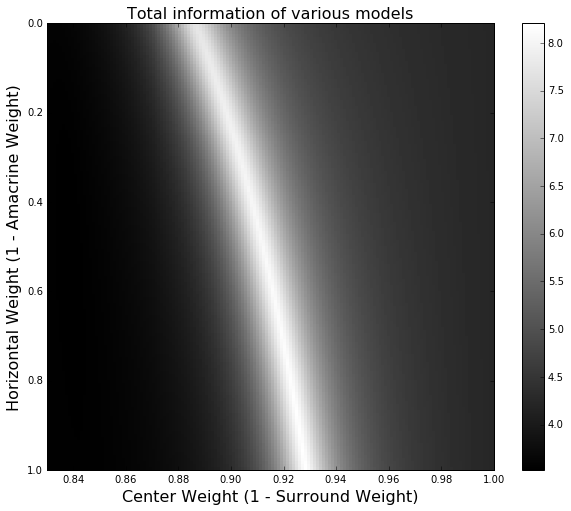

In [185]:
plt.imshow(info_color_map, cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

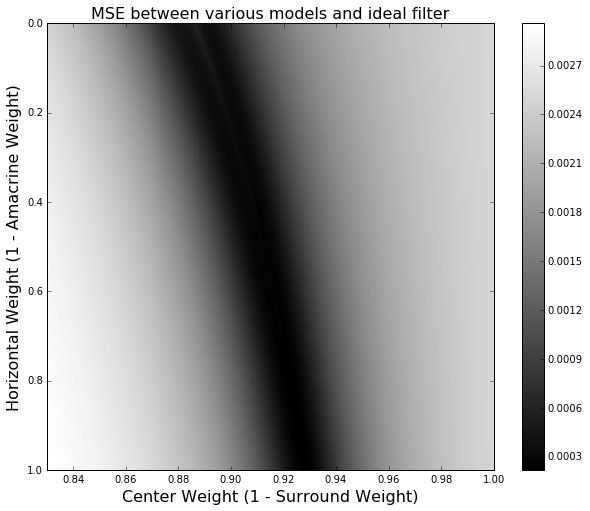

In [186]:
plt.imshow(mse_color_map, cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('MSE between various models and ideal filter', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

(0, 0.005)

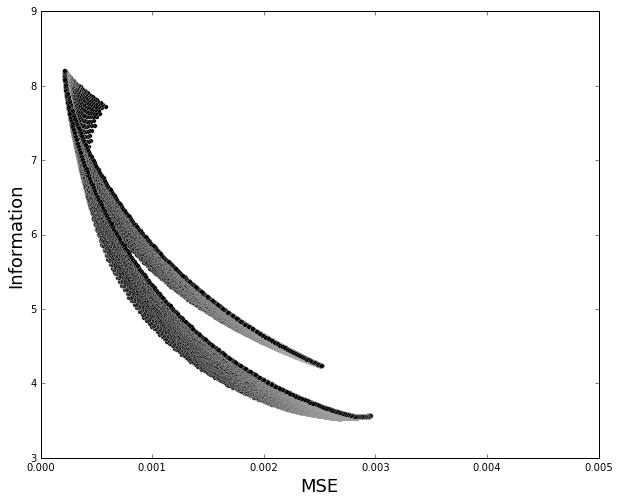

In [187]:
plt.scatter(mse_color_map.flat, info_color_map.flat, c='k', edgecolors='white', linewidths=0.2)
plt.xlabel('MSE', fontsize=18)
plt.ylabel('Information', fontsize=18)
plt.xlim([0,0.005])

In [189]:
np.mean((ideal_filter_interp(more_signal_freq) - filt_const*filt_interp(more_signal_freq))**2)

0.0025211205651523459

In [191]:
np.mean((ideal_filter_interp(lowerer_freqs) - filt_const*filt_interp(lowerer_freqs))**2)

0.1448774962025505

## investigate opposite extremes of horz weight

In [193]:
opposite_filters = []
hws = [horz_weights[1], horz_weights[-2]]
cws = []

for hw in hws:
    aw = 1.0 - hw
    cw = center_weights[np.argmax(info_color_map[np.argmin(abs(hw - horz_weights))])]
    sw = 1.0 - cw
    cws.append(cw)
    print('Horz weight %f, center weight %f, info %f' %(hw, cw, np.max(info_color_map[np.argmin(abs(hw - horz_weights))])))

    filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

    def constrain_filt_var(filt_const):
        output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                              (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                              (output_noise)**2)
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (output_variance - filt_variance)**2


    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    opposite_filters.append(filt_const * filt_interp(more_signal_freq))

Horz weight 0.006711, center weight 0.887047, info 7.724859
Horz weight 0.993289, center weight 0.928121, info 8.186726


(0, 0.4)

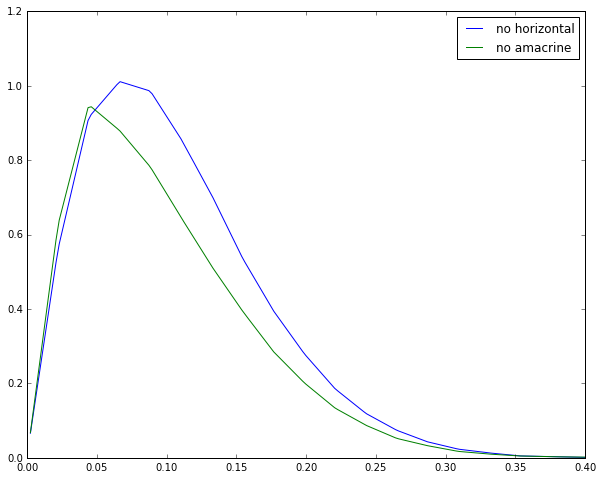

In [194]:
plt.plot(more_signal_freq, opposite_filters[0], 'b', label='no horizontal')
plt.plot(more_signal_freq, opposite_filters[1], 'g', label='no amacrine')
plt.legend()
plt.xlim([0,0.4])

In [195]:
filt_variance = np.sum((signal_interp(more_signal_freq)*opposite_filters[0])**2 +
                              (input_noise * opposite_filters[0])**2 +
                              (output_noise)**2)
filt_variance

1227.3451551838514

In [196]:
filt_variance = np.sum((signal_interp(more_signal_freq)*opposite_filters[1])**2 +
                              (input_noise * opposite_filters[1])**2 +
                              (output_noise)**2)
filt_variance

1227.345276206016

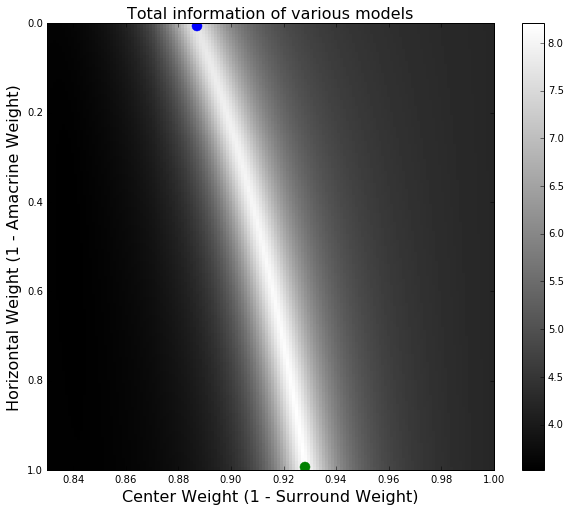

In [199]:
plt.imshow(info_color_map, cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.plot(cws[0], hws[0], 'b.', markersize=20)
plt.plot(cws[1], hws[1], 'g.', markersize=20)
plt.xlim([0.83,1])
plt.colorbar()
plt.title('Total information of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

## filter with ~0 horz weight is 95% efficient compared to filter with ~1 horz weight

#### Below, looking at exp(colormap)

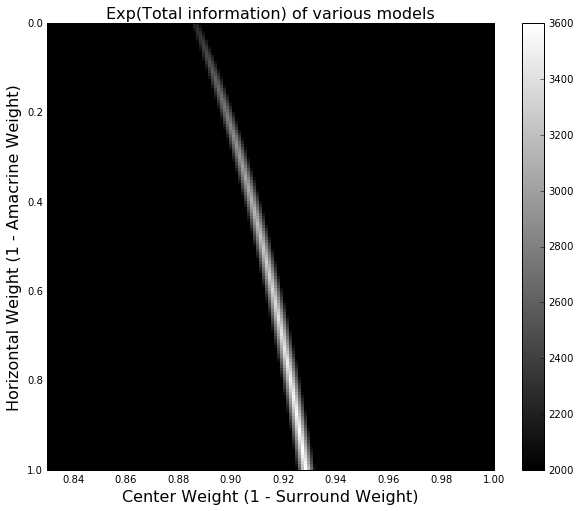

In [205]:
plt.imshow(np.exp(info_color_map), cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto', clim=[2000,3600])
plt.colorbar()
plt.title('Exp(Total information) of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)